# Generate word cloud from unstructured text data (e.g customer feedback)

- using sample customer feedback in CSV format on ergonomic chairs and desks from Contoso Pvt. Ltd.:
    - Q: what did you like about our products, what did you dislike about our products, how do you unwind and relax:
    - A: "The adjustable height feature is great for different tasks.","The assembly instructions were unclear.","I like reading a book in my favorite armchair."
    - A: "The minimalist design fits well in my home office.","The desk drawer is a bit stiff.","I take breaks to stretch and massage."


In [ ]:
%pip install wordcloud

### Import dependencies

In [181]:
from openai import AzureOpenAI
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import json
import os

### Initialize the azure openai client

In [160]:
# Configuration
AZURE_OPENAI_API_KEY = "<enter key>"
AZURE_OPENAI_ENDPOINT = "<enter endpoint>"

client = AzureOpenAI(
    # api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_key = AZURE_OPENAI_API_KEY,
    api_version= "2024-02-01",
    azure_endpoint = AZURE_OPENAI_ENDPOINT
    )
    
deployment_name= "gpt-4-32k" #"gpt-35-turbo-16k" #"gpt-4o"  #This will correspond to the custom name you chose for your deployment when you deployed a model. Use a gpt-35-turbo-instruct deployment. 

In [171]:
prompt = """
Summarize the following feedback text and extract key themes highlighting - likes, dislikes and hobbies as keywords - one word for each. 
Ignore any ID/identity columns or PII data (direct or indirect). 
Summarize each feedback in a single word which covers the sentiment. For example: 'Comfortable design supports back and posture' can be summarized as 'Comfortable'. 
But if the single word is incomplete add hyphenated additional word to make it meaningful. 'For example: The assembly instructions were unclear' can be summarized as 'Unclear instructions'.
Finally extract the three themes - likes, dislikes, hobbies as keys in lowercase from the summary into python dict.
For example:
{
"likes": ["comfortable", "adjustable", "excellent-support", "spacious-sturdy", "minimalist"],
"dislikes": ["low-armrests", "unclear-instructions", "stuck-wheels", "warm-fabric", "stiff-drawer"],
"hobbies": ["music-listening", "reading", "meditation", "tv-watching", "yoga"]
}
"""

### Define common functions: get keywords from feedback, generate word cloud

In [182]:
def get_keywords_from_feedback(feedback_text):
    """
    Uses OpenAI API to summarize the feedback text and extract keywords.
    
    Parameters:
    feedback_text (str): Customer feedback text.
    
    Returns:
    str: A string of keywords extracted from the feedback text.
    """
    response = client.chat.completions.create(
        model=deployment_name, 
        messages = [{"role":"system", "content":"You are a helpful assistant."},
                    {"role":"user","content":prompt+feedback_text}],
        max_tokens=10000,
        top_p=0.95,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
        temperature=0.5,
        )
    print(response.choices[0])
    keywords = response.choices[0].message.content
    return keywords
 
def generate_word_cloud(keywords, wc_title):
    """
    Generates and displays a word cloud from the given keywords.
    
    Parameters:
    keywords (str): The string of keywords for the word cloud.
    """
    # Create a word frequency dictionary
    word_freq_dict = Counter(keywords)
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_freq_dict)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(wc_title)
    plt.show()

### Execute main

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n"likes": ["comfortable", "adjustable", "excellent-support", "spacious-sturdy", "minimalist"],\n"dislikes": ["low-armrests", "unclear-instructions", "stuck-wheels", "warm-fabric", "stiff-drawer"],\n"hobbies": ["music-listening", "reading", "meditation", "tv-watching", "yoga"]\n}', role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})
Extracted Keywords: {
"likes": ["comfortable", "adjustable", "excellent-support", "spacious-sturdy", "minimalist"],
"dislikes": ["low-armrests", "unclear-instructions", "stuck-wheels", "warm-fabric", "stiff-drawer"],
"hobbies": ["music-listening", "reading", "meditation", "tv-watching", "yoga"]
}
['comfortable', 'adjustable', 'excelle

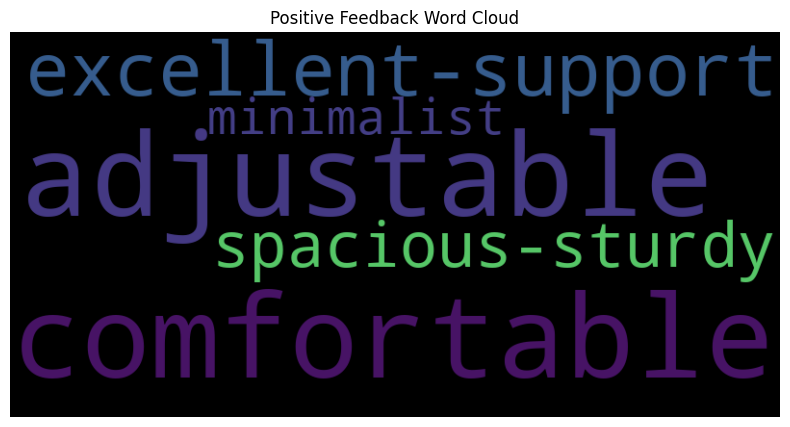

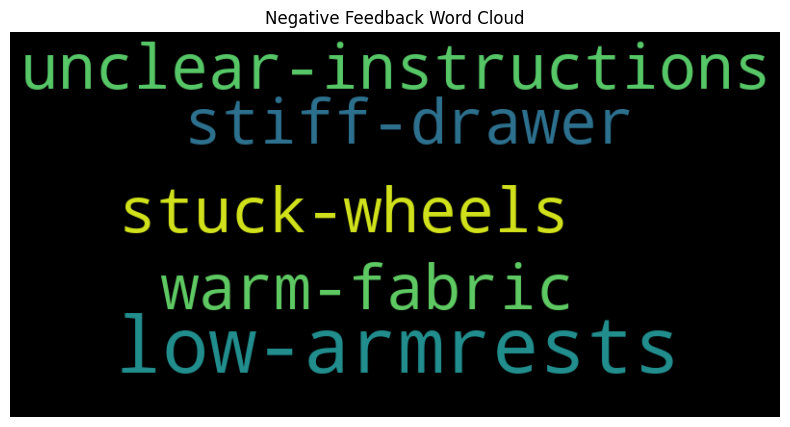

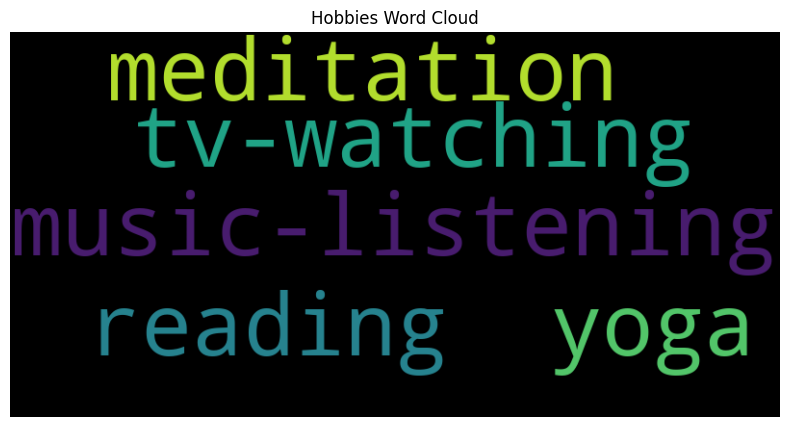

In [185]:
# main
def main():
    # Read feedback text (csv format)
    folder_path = "files"
    file_name = "feedback.txt"
    # df = spark.read.text("Files/data/feedback.txt") ## if you are using spark
    df = pd.read_csv(os.path.join(folder_path, file_name))
    # feedback_text = ' '.join([str(x.asDict()['value']) for x in df.collect()]) ## if you are using spark
    feedback_text = ' '.join(df.apply(lambda row: ' '.join(row.astype(str)), axis=1))
    
    # Get keywords using OpenAI GPT model
    keywords = get_keywords_from_feedback(feedback_text)
    print("Extracted Keywords:", keywords)

    # convert string to dict
    keywords_dict = json.loads(keywords)
    print(keywords_dict['likes'])

    # Generate the word cloud
    generate_word_cloud(keywords_dict['likes'], 'Positive Feedback Word Cloud')
    generate_word_cloud(keywords_dict['dislikes'], 'Negative Feedback Word Cloud')
    generate_word_cloud(keywords_dict['hobbies'], 'Hobbies Word Cloud')
 
if __name__ == "__main__":
    main()